# Rome neighborhoods clustering

I will try to analyze the wine stores in the central neighborhoods of Rome, to determine which could be a good guess to start the new Wine Shop. I will start by importing needed libraries.

In [179]:
import requests
import pandas as pd
import numpy as np

#!pip install geopy
from geopy.geocoders import Nominatim 
import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
import seaborn as sns

I use the csv file with the names of all Roma's zones. This file lists also very peripheral zone. Our interest is towards the center. In Rome the central neighborhoods are called 'RIONE', that's why we restrict our attention only to the RIONEs. 

In [180]:
da=pd.read_csv('Comprensori_Toponomastici.csv')
da.head()

,NOME;TIPOLOGIA
0,MONTI;RIONE
1,TREVI;RIONE
2,COLONNA;RIONE
3,CAMPO MARZIO;RIONE
4,PONTE;RIONE


In [181]:
da=da[da['NOME;TIPOLOGIA'].str.contains('RIONE')]
da.head(30)

,NOME;TIPOLOGIA
0,MONTI;RIONE
1,TREVI;RIONE
2,COLONNA;RIONE
3,CAMPO MARZIO;RIONE
4,PONTE;RIONE
5,PARIONE;RIONE
6,REGOLA;RIONE
7,SANT'EUSTACHIO;RIONE
8,PIGNA;RIONE
9,CAMPITELLI;RIONE


I now search for coordinates of each RIONE. Some of these coordinates are not retrievable, so I will limit my attention to the RIONEs for which I can recall the coordinates.

In [182]:
names=[]
latitudes=[]
longitudes=[]
for item in da.values:
    address = item+', Rome'
    print(item)
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    if location is None:
        print(location)
    else:
        names.append(item[0])
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)


['MONTI;RIONE']
['TREVI;RIONE']
['COLONNA;RIONE']
['CAMPO MARZIO;RIONE']
['PONTE;RIONE']
['PARIONE;RIONE']
['REGOLA;RIONE']
["SANT'EUSTACHIO;RIONE"]
['PIGNA;RIONE']
['CAMPITELLI;RIONE']
["SANT'ANGELO;RIONE"]
['RIPA;RIONE']
['TRASTEVERE;RIONE']
['BORGO;RIONE']
['ESQUILINO;RIONE']
['LUDOVISI;RIONE']
['SALLUSTIANO;RIONE']
['CASTRO PRETORIO;RIONE']
['CELIO;RIONE']
['TESTACCIO;RIONE']
['SAN SABA;RIONE']
None
['PRATI;RIONE']


The only RIONE for which I cannot find coordinates is San Saba. I then create a new dataframe with the retrieved RIONEs, and map them.

In [183]:
coord=pd.DataFrame(names)
coord.columns=['neigh']

coord['lat']=latitudes
coord['lng']=longitudes
coord.tail()

,neigh,lat,lng
16,SALLUSTIANO;RIONE,41.907724,12.490797
17,CASTRO PRETORIO;RIONE,41.906298,12.505559
18,CELIO;RIONE,41.888552,12.494115
19,TESTACCIO;RIONE,41.878065,12.474757
20,PRATI;RIONE,41.908329,12.464388


In [184]:
latitude=41.9109 
longitude=12.4818
# create map of Roma using latitude and longitude values
map_Rome = folium.Map(location=[latitude, longitude], zoom_start=13)

for lat, lng, name in zip(coord.lat, coord.lng, coord.neigh):
    folium.features.Marker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=name,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(map_Rome)


map_Rome

I add my credentials for foursquare in order to search for venues in each RIONE that answer the query 'wine':

In [185]:
CLIENT_ID = '3GBYNQRL5Q1R44GR4C3IS32VX3IFLDNIQCC0YMJDL0BBKWKT' # your Foursquare ID
CLIENT_SECRET = 'XGYBBU1IPH0JVX3AISVXVWKVJ0PRACEQ054FB0YQIWRGITSE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3GBYNQRL5Q1R44GR4C3IS32VX3IFLDNIQCC0YMJDL0BBKWKT
CLIENT_SECRET:XGYBBU1IPH0JVX3AISVXVWKVJ0PRACEQ054FB0YQIWRGITSE


In [186]:
def getNearbyVenues(names, latitudes, longitudes, query, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            lat, 
            lng, 
            VERSION, 
            query,
            radius, 
            LIMIT)
            
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        try: 
            venues_list.append([(name, lat, lng, v['name'], 
                                 v['location']['lat'], 
                                 v['location']['lng'],# ) for v in results]) 
                                 v['categories'][0]['name']) for v in results])
        except: 
            venues_list.append([(name, lat, lng, v['name'], 
                                 v['location']['lat'], 
                                 v['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Category' ]
    
    return(nearby_venues)

In [187]:
Roma_venues = getNearbyVenues(names=coord.neigh,
                                   latitudes=coord.lat,
                                   longitudes=coord.lng, query='wine'
                                  )

MONTI;RIONE
TREVI;RIONE
COLONNA;RIONE
CAMPO MARZIO;RIONE
PONTE;RIONE
PARIONE;RIONE
REGOLA;RIONE
SANT'EUSTACHIO;RIONE
PIGNA;RIONE
CAMPITELLI;RIONE
SANT'ANGELO;RIONE
RIPA;RIONE
TRASTEVERE;RIONE
BORGO;RIONE
ESQUILINO;RIONE
LUDOVISI;RIONE
SALLUSTIANO;RIONE
CASTRO PRETORIO;RIONE
CELIO;RIONE
TESTACCIO;RIONE
PRATI;RIONE


Unfortunately some of the entries have missing values for the category of the venues. From a rapid search I identifiy that this happens for two RIONEs, Ludovisi and Sallustiano, so I drop these values. I drop them also on the coord dataframe. 

In [188]:
Roma_venues.shape

(112, 7)

In [189]:
Roma_venues[Roma_venues['Category'].isnull()]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Category
92,LUDOVISI;RIONE,41.907523,12.489380,American Wine Bar,41.907776,12.488805,None
93,LUDOVISI;RIONE,41.907523,12.489380,Time Restaurant and Wine Bar,41.908174,12.489403,None
94,LUDOVISI;RIONE,41.907523,12.489380,Peluso wine shop,41.909705,12.491585,None
95,LUDOVISI;RIONE,41.907523,12.489380,International Wine Academy of Roma,41.906195,12.482990,None
96,LUDOVISI;RIONE,41.907523,12.489380,*****Wine Cockails Bar 900*****,41.905888,12.483475,None
97,LUDOVISI;RIONE,41.907523,12.489380,La Fenice Wine Bar,41.905013,12.485877,None
98,LUDOVISI;RIONE,41.907523,12.489380,Grill & Wine Restaurant,41.904384,12.486757,None
99,LUDOVISI;RIONE,41.907523,12.489380,*****Cafetteria Wine Cockails Bar 900*****,41.905666,12.483896,None
100,LUDOVISI;RIONE,41.907523,12.489380,Il Palazzetto Wine Bar,41.906354,12.482846,None
101,SALLUSTIANO;RIONE,41.907724,12.490797,Time Restaurant and Wine Bar,41.908174,12.489403,None


In [190]:
Roma_venues=Roma_venues[Roma_venues['Neighborhood'] != 'LUDOVISI;RIONE']
Roma_venues=Roma_venues[Roma_venues['Neighborhood'] != 'SALLUSTIANO;RIONE']
print(Roma_venues.shape)
Roma_venues.groupby('Neighborhood').count()

(98, 7)


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Category
Neighborhood,,,,,,
BORGO;RIONE,5,5,5,5,5,5
CAMPITELLI;RIONE,2,2,2,2,2,2
CAMPO MARZIO;RIONE,15,15,15,15,15,15
CASTRO PRETORIO;RIONE,1,1,1,1,1,1
CELIO;RIONE,4,4,4,4,4,4
COLONNA;RIONE,1,1,1,1,1,1
ESQUILINO;RIONE,5,5,5,5,5,5
MONTI;RIONE,6,6,6,6,6,6
PARIONE;RIONE,9,9,9,9,9,9


[Text(0, 0, 'MONTI'),
 Text(0, 0, 'TREVI'),
 Text(0, 0, 'COLONNA'),
 Text(0, 0, 'CAMPO MARZIO'),
 Text(0, 0, 'PONTE'),
 Text(0, 0, 'PARIONE'),
 Text(0, 0, 'REGOLA'),
 Text(0, 0, "SANT'EUSTACHIO"),
 Text(0, 0, 'PIGNA'),
 Text(0, 0, 'CAMPITELLI'),
 Text(0, 0, "SANT'ANGELO"),
 Text(0, 0, 'TRASTEVERE'),
 Text(0, 0, 'BORGO'),
 Text(0, 0, 'ESQUILINO'),
 Text(0, 0, 'CASTRO PRETORIO'),
 Text(0, 0, 'CELIO'),
 Text(0, 0, 'PRATI')]

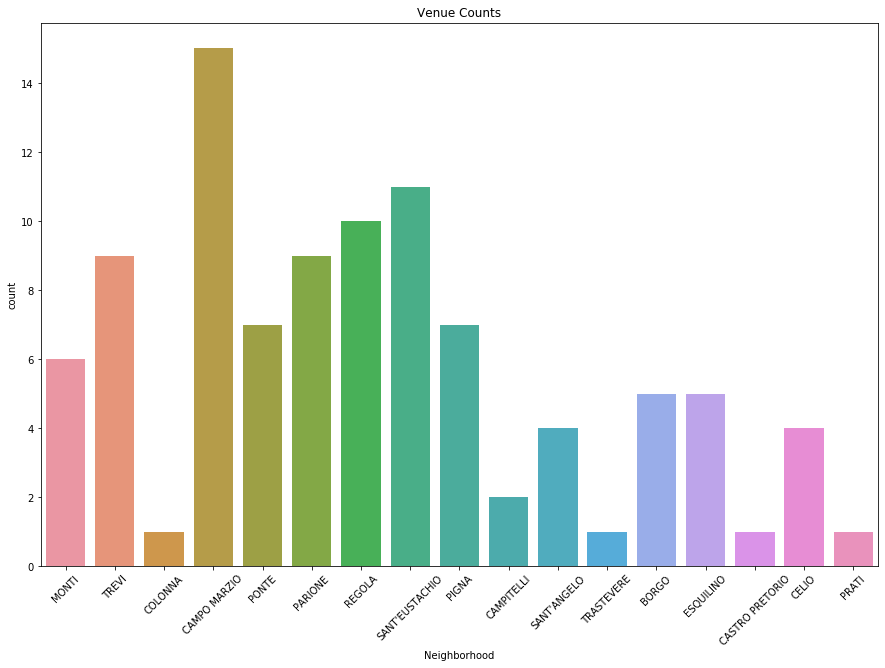

In [191]:
plt.figure(figsize=(15,10))
ax= sns.countplot(data=Roma_venues,x='Neighborhood')
labels=[]
for item in Roma_venues['Neighborhood'].unique():
    labels.append(item[0:-6])
    
ax.set_title('Venue Counts')
ax.set_xticklabels(labels,rotation=45)

In [192]:
coord=coord[coord['neigh'] != 'LUDOVISI;RIONE']
coord=coord[coord['neigh'] != 'SALLUSTIANO;RIONE']
coord=coord[coord['neigh'] != 'RIPA;RIONE']
coord=coord[coord['neigh'] != 'TESTACCIO;RIONE']


coord.head(22)

,neigh,lat,lng
0,MONTI;RIONE,41.895813,12.493587
1,TREVI;RIONE,41.900978,12.483285
2,COLONNA;RIONE,41.895821,12.484269
3,CAMPO MARZIO;RIONE,41.904647,12.477055
4,PONTE;RIONE,41.897698,12.465756
5,PARIONE;RIONE,41.897358,12.471103
6,REGOLA;RIONE,41.894375,12.471030
7,SANT'EUSTACHIO;RIONE,41.898244,12.475321
8,PIGNA;RIONE,41.897116,12.479196
9,CAMPITELLI;RIONE,41.890085,12.487416


In [193]:
print('There are {} uniques categories.'.format(len(Roma_venues['Category'].unique())))

There are 16 uniques categories.


[Text(0, 0, 'Bar'),
 Text(0, 0, 'Wine Bar'),
 Text(0, 0, 'Café'),
 Text(0, 0, 'Cocktail Bar'),
 Text(0, 0, 'Residential Building (Apartment / Condo)'),
 Text(0, 0, 'Restaurant'),
 Text(0, 0, 'Italian Restaurant'),
 Text(0, 0, 'Winery'),
 Text(0, 0, 'Lounge'),
 Text(0, 0, 'School'),
 Text(0, 0, 'Brewery'),
 Text(0, 0, 'General Entertainment'),
 Text(0, 0, 'Seafood Restaurant'),
 Text(0, 0, 'Gourmet Shop'),
 Text(0, 0, 'Pub'),
 Text(0, 0, 'Pizza Place')]

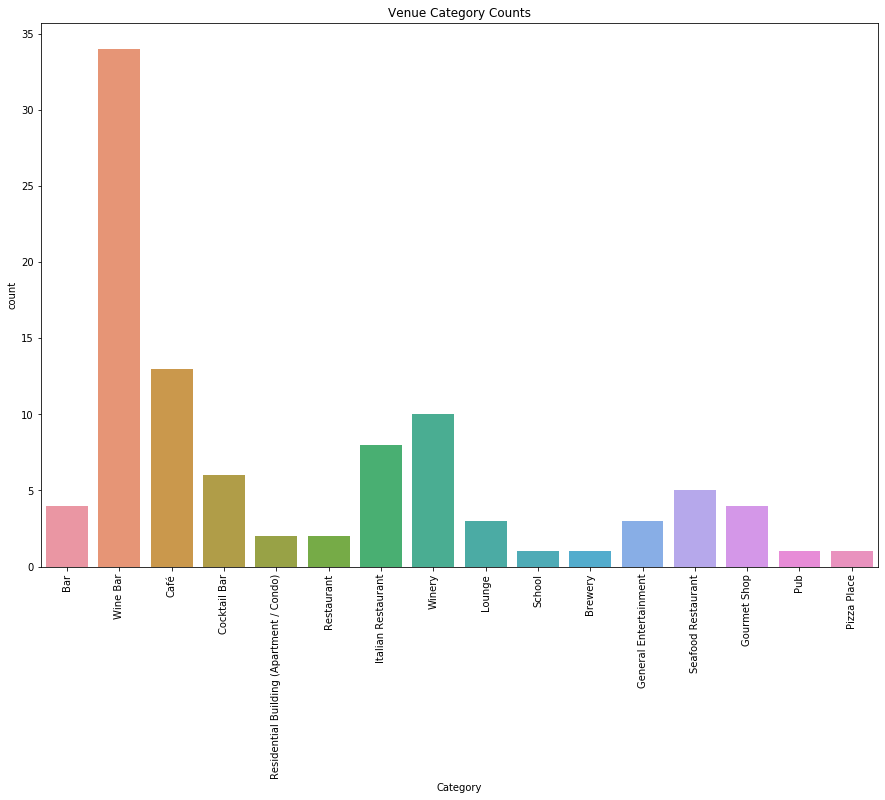

In [194]:
plt.figure(figsize=(15,10))
ax= sns.countplot(data=Roma_venues,x='Category')
labels=Roma_venues.Category.unique()
ax.set_title('Venue Category Counts')
ax.set_xticklabels(labels,rotation=90)

I hot encode the categories, to be able to determine the most common venues by neighborhood.

In [195]:
# one hot encoding
rom_onehot = pd.get_dummies(Roma_venues[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
rom_onehot['Neighborhood'] = Roma_venues['Neighborhood'] 

# move neighborhood column to the first column
nei = rom_onehot['Neighborhood']
rom_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
rom_onehot.insert(0, 'Neighborhood', nei)

rom_onehot.head()

,Neighborhood,Bar,Brewery,Café,Cocktail Bar,General Entertainment,Gourmet Shop,Italian Restaurant,Lounge,Pizza Place,Pub,Residential Building (Apartment / Condo),Restaurant,School,Seafood Restaurant,Wine Bar,Winery
0,MONTI;RIONE,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,MONTI;RIONE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,MONTI;RIONE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,MONTI;RIONE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,MONTI;RIONE,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [196]:
rom_onehot.shape

(98, 17)

In [197]:
rom_group = rom_onehot.groupby('Neighborhood').mean().reset_index()
rom_group.shape

(17, 17)

In [198]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [199]:
Roma_venues.groupby('Neighborhood').count().describe()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Category
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,5.764706,5.764706,5.764706,5.764706,5.764706,5.764706
std,4.085484,4.085484,4.085484,4.085484,4.085484,4.085484
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
75%,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
max,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000


I select just 5 top venues, using the median value of the venue counts for each neighborhood.

In [200]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = rom_group['Neighborhood']

for ind in np.arange(rom_group.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(rom_group.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,BORGO;RIONE,Winery,Pub,General Entertainment,Café,Wine Bar
1,CAMPITELLI;RIONE,Café,Winery,Wine Bar,Seafood Restaurant,School
2,CAMPO MARZIO;RIONE,Wine Bar,Italian Restaurant,Winery,School,Restaurant
3,CASTRO PRETORIO;RIONE,Winery,Wine Bar,Seafood Restaurant,School,Restaurant
4,CELIO;RIONE,Wine Bar,Pizza Place,Café,Winery,Seafood Restaurant


I finally run kmeans with 5 clusters to see the results, and plot the results on a map. 

In [201]:
# set number of clusters
kclusters = 5

rom_clus = rom_group.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=100, max_iter=1000).fit(rom_clus)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 0, 2, 1, 3, 1, 1, 1, 1], dtype=int32)

In [202]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

rom_merge = coord

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
rom_merge = rom_merge.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='neigh',how='inner')

rom_merge.head() # check the last columns!

,neigh,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,MONTI;RIONE,41.895813,12.493587,1,Wine Bar,Residential Building (Apartment / Condo),Cocktail Bar,Café,Bar
1,TREVI;RIONE,41.900978,12.483285,0,Italian Restaurant,Winery,Wine Bar,Restaurant,Lounge
2,COLONNA;RIONE,41.895821,12.484269,3,Café,Winery,Wine Bar,Seafood Restaurant,School
3,CAMPO MARZIO;RIONE,41.904647,12.477055,0,Wine Bar,Italian Restaurant,Winery,School,Restaurant
4,PONTE;RIONE,41.897698,12.465756,1,Wine Bar,Seafood Restaurant,General Entertainment,Cocktail Bar,Café


In [203]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(rom_merge['lat'], rom_merge['lng'], rom_merge['neigh'], rom_merge['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The result shows 2 populated clusters and 3 clusters composed by only one/two neighborhoods. Lets see them in details.

In [204]:
rom_merge[rom_merge['Cluster Labels']==0] #red

,neigh,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,TREVI;RIONE,41.900978,12.483285,0,Italian Restaurant,Winery,Wine Bar,Restaurant,Lounge
3,CAMPO MARZIO;RIONE,41.904647,12.477055,0,Wine Bar,Italian Restaurant,Winery,School,Restaurant
10,SANT'ANGELO;RIONE,41.901758,12.468148,0,Seafood Restaurant,Italian Restaurant,General Entertainment,Café,Winery
13,BORGO;RIONE,41.903900,12.459657,0,Winery,Pub,General Entertainment,Café,Wine Bar


In [205]:
rom_merge[rom_merge['Cluster Labels']==1] #purple

,neigh,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,MONTI;RIONE,41.895813,12.493587,1,Wine Bar,Residential Building (Apartment / Condo),Cocktail Bar,Café,Bar
4,PONTE;RIONE,41.897698,12.465756,1,Wine Bar,Seafood Restaurant,General Entertainment,Cocktail Bar,Café
5,PARIONE;RIONE,41.897358,12.471103,1,Wine Bar,Seafood Restaurant,Gourmet Shop,Cocktail Bar,Café
6,REGOLA;RIONE,41.894375,12.471030,1,Wine Bar,Seafood Restaurant,Gourmet Shop,Cocktail Bar,Café
7,SANT'EUSTACHIO;RIONE,41.898244,12.475321,1,Wine Bar,Winery,Seafood Restaurant,Lounge,Gourmet Shop
8,PIGNA;RIONE,41.897116,12.479196,1,Wine Bar,Winery,Lounge,Gourmet Shop,Café
14,ESQUILINO;RIONE,41.898044,12.498863,1,Wine Bar,Residential Building (Apartment / Condo),Cocktail Bar,Bar,Winery
18,CELIO;RIONE,41.888552,12.494115,1,Wine Bar,Pizza Place,Café,Winery,Seafood Restaurant


In [206]:
rom_merge[rom_merge['Cluster Labels']==2] #blue

,neigh,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,TRASTEVERE;RIONE,41.887263,12.462117,2,Winery,Wine Bar,Seafood Restaurant,School,Restaurant
17,CASTRO PRETORIO;RIONE,41.906298,12.505559,2,Winery,Wine Bar,Seafood Restaurant,School,Restaurant


In [207]:
rom_merge[rom_merge['Cluster Labels']==3] #green

,neigh,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,COLONNA;RIONE,41.895821,12.484269,3,Café,Winery,Wine Bar,Seafood Restaurant,School
9,CAMPITELLI;RIONE,41.890085,12.487416,3,Café,Winery,Wine Bar,Seafood Restaurant,School


In [208]:
rom_merge[rom_merge['Cluster Labels']==4] #orange

,neigh,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
20,PRATI;RIONE,41.908329,12.464388,4,Italian Restaurant,Winery,Wine Bar,Seafood Restaurant,School


Looking at results, I will suggest to look at cluster 1. It collects all the turistic zones, that indeed shows a lot of gourmet wine shops. The guideline should be to select one neighborhood from cluster 1 that has not yet gourmet wine shops. 